In [33]:
# Importing essential modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
# It makes sure that pandas datatypes like pd.Timestamp can be used in matplotlib plots without having to cast them to another type.
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf,pacf
# Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors, or SARIMAX, is an extension of the ARIMA class of models. 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
register_matplotlib_converters()

Catfish Sales Data

In [3]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

In [4]:
# Read Data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# By default, date columns are represented as object when loading data from a CSV file. To read the date column correctly, we can use the argument parse_dates to specify a list of date columns.

In [5]:
# Frequency of the Data
# asfreq() function is used to convert TimeSeries to specified frequency
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [6]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
# Limited Catfish Sales
lim_catfish_sales = catfish_sales[start_date:end_date]

Introducing an Anomaly

In [7]:
# At December 1 1998
lim_catfish_sales[datetime(1998,12,1)] = 10000

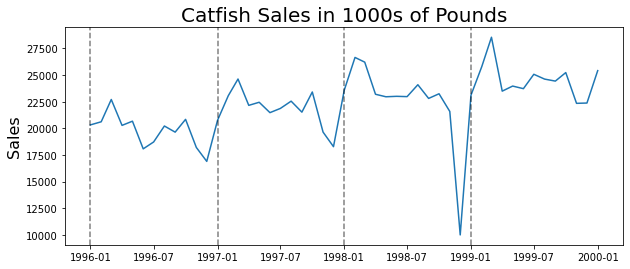

In [77]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
# axvline() function in axes module of matplotlib library is used to add a vertical line across the axis.
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

Remove the trend

In [9]:
# Calculating the nth discrete difference along the given axis
first_diff = lim_catfish_sales.diff()[1:]

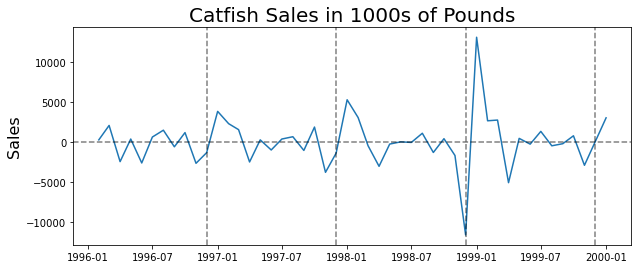

In [74]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)
plt.axhline(0,color='k',linestyle='--',alpha=0.5)

Get Training and Testing sets

In [11]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

Make Predictions

In [12]:
# Tuples
my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)

In [13]:
rolling_predictions = test_data.copy() # The copy() method in Python returns a copy of the Set.
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end - timedelta(days=1)]
    model = SARIMAX(train_data,order = my_order,seasonal_order = my_seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\KIIT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\KIIT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\KIIT\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\KIIT\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

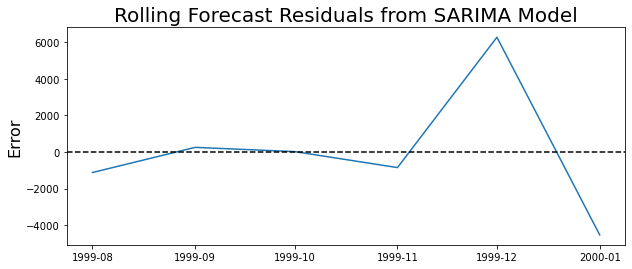

In [16]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0,linestyle='--',color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

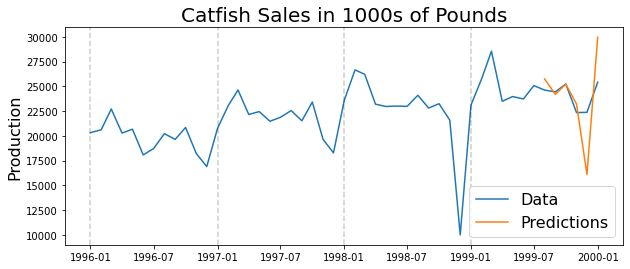

In [72]:
# Rolling Predictions
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)
plt.legend(('Data','Predictions'),fontsize=16)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [18]:
# Rounding upto required decimal places
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0922


In [19]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 3211.745605326383


# Detecting the Anomaly

Attempt 1: Deviation Method

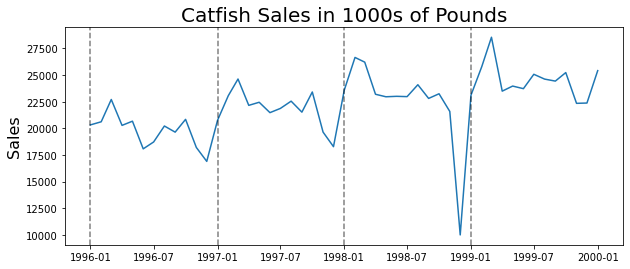

In [26]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.5)

In [25]:
rolling_deviations = pd.Series(dtype = float,index = lim_catfish_sales.index)

In [27]:
for date in rolling_deviations.index:
    # Get the window ending at this data point
    window = lim_catfish_sales.loc[:date]
    # Get the deviation within this window
    rolling_deviations.loc[date] = window.std() # Computing Standard deviation 

In [28]:
# Get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

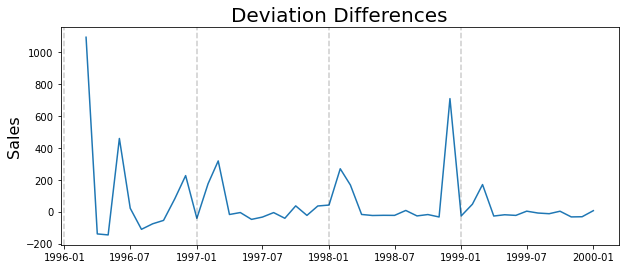

In [29]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Attempt 2: Seasonal Method

In [30]:
month_deviations = lim_catfish_sales.groupby(lambda d: d.month).std()

Text(0, 0.5, 'Sales')

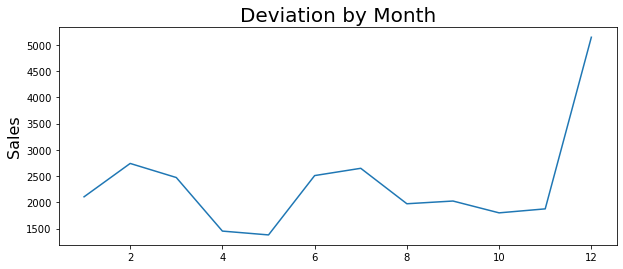

In [39]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month',fontsize=20)
plt.ylabel('Sales',fontsize=16)

It can be seen month of December has the highest deviation. Clearly it shows the anomaly occurs in a December

In [40]:
december_data = lim_catfish_sales[lim_catfish_sales.index.month == 12]

In [41]:
december_data

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    10000
1999-12-01    22372
Name: Total, dtype: int64

In [45]:
min_dev = 9999999
curr_anomaly = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [46]:
curr_anomaly

Timestamp('1998-12-01 00:00:00')

Our Created Anomaly

# Over-coming the Anomaly

Using Mean of other months

In [52]:
adjusted_data = lim_catfish_sales.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

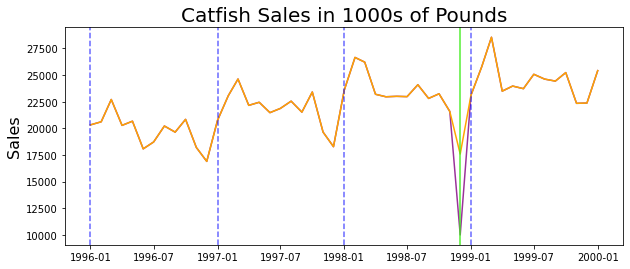

In [71]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales,color='purple',alpha=0.8)
plt.plot(adjusted_data,color='orange')
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'),color='blue',alpha=0.6,linestyle='--')
plt.axvline(curr_anomaly,color='#3fed1c',alpha=0.9)

# Resulting Predictions

In [79]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)
test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [80]:
rolling_predictions = test_data.copy()

In [81]:
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data,order=my_order,seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\KIIT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\KIIT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\KIIT\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

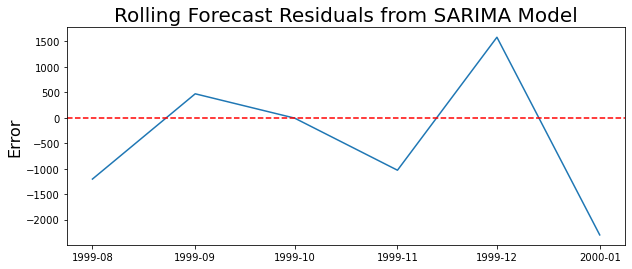

In [86]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

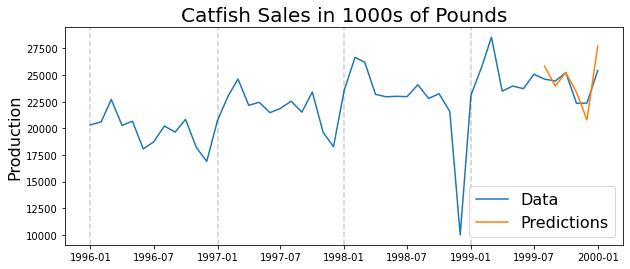

In [88]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Now prediction is more acccurate

In [89]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.046


In [90]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1324.7472085898753
